# Monitoring Urban Sprawl with Sentinel-1 SAR Data: Pixel Value and Polarization Thresholding 

In this notebook, we will present a simple example of how you can access data from CREODIAS and what you can do with it. We will demonstrate how to utilize thresholding techniques and compare the values of VV and VH polarizations to analyze urban areas. As an illustration, we will attempt to download Sentinel-1 images containing data of the urban area of Warsaw.

Author: Tomasz Furtak

## 1. Prerequisites

### 1.1. CREODIAS Account

You need a CREODIAS hosting account with access to the Horizon interface: [CREODIAS Horizon Interface](https://horizon.cloudferro.com).

### 1.2. S3 Access

Ensure you have S3 access credentials. You will need an access key and a secret key to interact with the CREODIAS S3 storage.

### 1.3. Installing Jupyter Notebook

The code in this guide runs on Jupyter Notebook. You can install it on your platform of choice by following the [official Jupyter Notebook install page](https://jupyter.org/install).

One particular way of installing Jupyter Notebook, though not required for this guide, is to set it up on a Kubernetes cluster. If this is of interest, the following article might be useful:

[Installing JupyterHub on Magnum Kubernetes Cluster in CREODIAS Cloud](https://www.cloudferro.com/en/blog/tutorials/installing-jupyterhub-on-magnum-kubernetes-cluster-in-creodias-cloud/).

Additionally, it is possible to use the online Jupyter Notebook served by the Copernicus Data Space Ecosystem (CDSE), where all the necessary libraries are already predefined in the 'geoscience' kernel.

[CDSE JupyterLab](https://documentation.dataspace.copernicus.eu/Applications/JupyterHub.html#notebooks).

### 1.4. Python Libraries

Ensure you have the following Python libraries installed, which are required for running the code:
- `json`
- `requests`
- `os`
- `boto3`
- `datetime`
- `numpy`
- `rasterio`
- `matplotlib`
- `zipfile`
- `io`

You can install these libraries using pip:
`pip install json requests boto3 numpy rasterio matplotlib`


## 2. Accessing data from CREODIAS

### 2.1. Imports and Variable Declarations

In [1]:
import json
import requests
import os
import boto3
import datetime
import numpy as np
import rasterio
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import zipfile
import io

### 2.2. S3 Configuration and Function to List TIFF Files

In [3]:
# S3 access keys
access_key = 'your_access_key'
secret_key = 'your_secret_key'
host = 'http://eodata.cloudferro.com'
c
# Initialize the S3 client with the custom endpoint
s3 = boto3.client('s3',
                  aws_access_key_id=access_key,
                  aws_secret_access_key=secret_key,
                  endpoint_url=host)

# Function to list TIFF files in the S3 bucket
def list_tiff_files_in_s3(prefix):
    tiff_files = []
    response = s3.list_objects_v2(Bucket='DIAS', Prefix=prefix)

    for obj in response.get('Contents', []):
        if obj['Key'].lower().endswith('.tiff') or obj['Key'].lower().endswith('.tif'):
            tiff_files.append(obj['Key'])

    return tiff_files


In [2]:
# Settings for the API query
collection = 'SENTINEL-1'
product_type = 'GRD'
start_date = '2024-05-15T00:00:00.000Z'
end_date = '2024-05-17T00:05:00.000Z'
polygon_coords = '20.851215 52.261859, 21.271151 52.261859, 21.271151 52.017798, 20.851215 52.017798, 20.851215 52.261859'

# Creating URL with query parameters
url = f"https://datahub.creodias.eu/odata/v1/Products?$filter=Collection/Name eq '{collection}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and ContentDate/Start gt {start_date} and ContentDate/End lt {end_date} and OData.CSC.Intersects(area=geography'SRID=4326;POLYGON(({polygon_coords}))')&$expand=Attributes&$top=1"

### 2.3. Fetching Product Path from API Response

In [4]:
# Fetch product path from the API response
response = requests.get(url)
products = json.loads(response.text)

# Extract the S3 path from the first product in the response
product_path = ''
for item in products.get('value', []):
    product_path = item.get('S3Path')
    break
    
# Replace '/eodata/' in the product_path if needed
product_path = product_path.replace('/eodata/', '') + '/'

### 2.4. Downloading TIFF Files from S3 and Saving Locally

In [5]:
# List TIFF files in the S3 bucket
output_dir = os.path.join(os.getcwd(), 'sen_1')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create directory if it doesn't exist
tiff_files = list_tiff_files_in_s3(product_path)

# Download TIFF files
for file in tiff_files:
    file_name = os.path.basename(file)
    local_file_path = os.path.join(output_dir, file_name)
    s3.download_file('DIAS', file, local_file_path)
    print(f'Downloaded: {file_name}')

Downloaded: s1a-iw-grd-vh-20240516t162754-20240516t162819-053899-068d12-002.tiff
Downloaded: s1a-iw-grd-vv-20240516t162754-20240516t162819-053899-068d12-001.tiff


# 3. Urban areas extraction by tresholding
The analysis of Synthetic Aperture Radar (SAR) images enables the detection of variations in radar wave reflections, which is crucial for identifying urbanized areas. SAR images exhibit distinct reflection patterns that allow for the delineation of urban areas, including agglomerations and smaller urban settlements. Urbanized areas stand out in these images primarily due to the intense reflection of radar waves by man-made structures, roads, and other artificial elements of infrastructure, facilitating their clear identification contrasted with natural terrain. Such analysis of areas like the Warsaw agglomeration can serve for monitoring city growth and development, urban planning, assessment of natural and anthropogenic threats, and environmental management. The image clearly depicts the Warsaw agglomeration area, adjacent to the region between the Warsaw and Łódź agglomerations. This space is currently planned for development to connect both agglomerations. In the central part of the frame, there are plans for establishing a large airport complex.

### 3.1. Reading and preprocessing data

The first step in our analysis will be data reading. The data will be read using the rasterio library from the output folder path provided in the previous section.

In [6]:
# Function to find files containing specific substrings ("vv" and "vh") in their names
def find_files_with_names(folder_path):
    vv_path = None  
    vh_path = None  
    
    for root, dirs, files in os.walk(folder_path):
        print(files)
        for file_name in files:
            if "vv" in file_name:
                vv_path = os.path.join(root, file_name)
            if "vh" in file_name:
                vh_path = os.path.join(root, file_name)
    
    return vv_path, vh_path
output_dir = 'sen_1'
# Find the "vv" and "vh" files in the specified directory
input_file_vv, input_file_vh = find_files_with_names(output_dir)
print(input_file_vv)
# Open the "vv" file and read its data and profile
with rasterio.open(input_file_vv) as src_vv:
    vv_band = src_vv.read(1)
    profile_vv = src_vv.profile

# Open the "vh" file and read its data and profile
with rasterio.open(input_file_vh) as src_vh:
    vh_band = src_vh.read(1)
    profile_vh = src_vh.profile
    
# Set CRS and transform manually if they are missing
crs = 'EPSG:4326' 
transform = Affine.translation(0.0, 0.0) * Affine.scale(30.0, -30.0) 
profile_vv.update(crs=crs, transform=transform)
profile_vh.update(crs=crs, transform=transform)

['s1a-iw-grd-vv-20240516t162754-20240516t162819-053899-068d12-001.tiff', 's1a-iw-grd-vh-20240516t162754-20240516t162819-053899-068d12-002.tiff']
sen_1/s1a-iw-grd-vv-20240516t162754-20240516t162819-053899-068d12-001.tiff


### 3.2. Pixel value covertion to decibels
After reading the data, we can convert the pixel values to decibels. Data from Sentinel-1 is converted to the decibel scale (dB) to better visualize differences in the intensity of radar wave reflection, which aids in the analysis of urban areas due to their specific reflection characteristics. 

The highest peak of the VV polarization histogram is in the range of 15-20 dB, suggesting that most surfaces in the studied area have moderate radar backscatter. The threshold of 23.5 dB is chosen to highlight pixels with the highest radar backscatter values, which may correspond to areas with intense urban infrastructure or other features with high reflectivity.

The highest peak of the VH polarization histogram is in the range of 13-18 dB, suggesting that this channel is more sensitive to surfaces with lower radar backscatter. The threshold of 21.5 dB for the VH channel is appropriate to identify pixels with higher backscatter, which helps to better differentiate terrain structures with slightly lower but still significant backscatter.

In [7]:
def convert_to_db(image):
    # Create a copy of the image to avoid modifying the original array
    image = np.copy(image)
    
    # Replace non-positive values with a small positive value to avoid taking log of zero or negative
    image[image <= 0] = np.finfo(float).eps  
    
    # Calculate dB values
    with np.errstate(divide='ignore', invalid='ignore'): 
        image_db = 10 * np.log10(image)
    
    # Replace infinite values with the maximum finite value
    max_value = np.nanmax(image_db[np.isfinite(image_db)])  
    image_db[np.isinf(image_db)] = max_value  

    return image_db

vv_band_db = convert_to_db(vv_band)
vh_band_db = convert_to_db(vh_band)

### 3.3. Data analysis and tresholding

The next step involves plotting histograms of the decibel pixel values for both the VV and VH bands. These histograms provide insights into the distribution of radar reflection intensities, aiding in understanding the characteristics of the observed area. The chosen thresholds, 23.5 dB for VV and 21.5 dB for VH, are selected based on prior knowledge or analysis requirements specific to urban areas to segment regions of interest in the images. The thresholding method applied here converts pixel values above the threshold to 1 and those below to 0, aiding in the delineation of features or areas with specific radar reflection characteristics typical of urban environments.

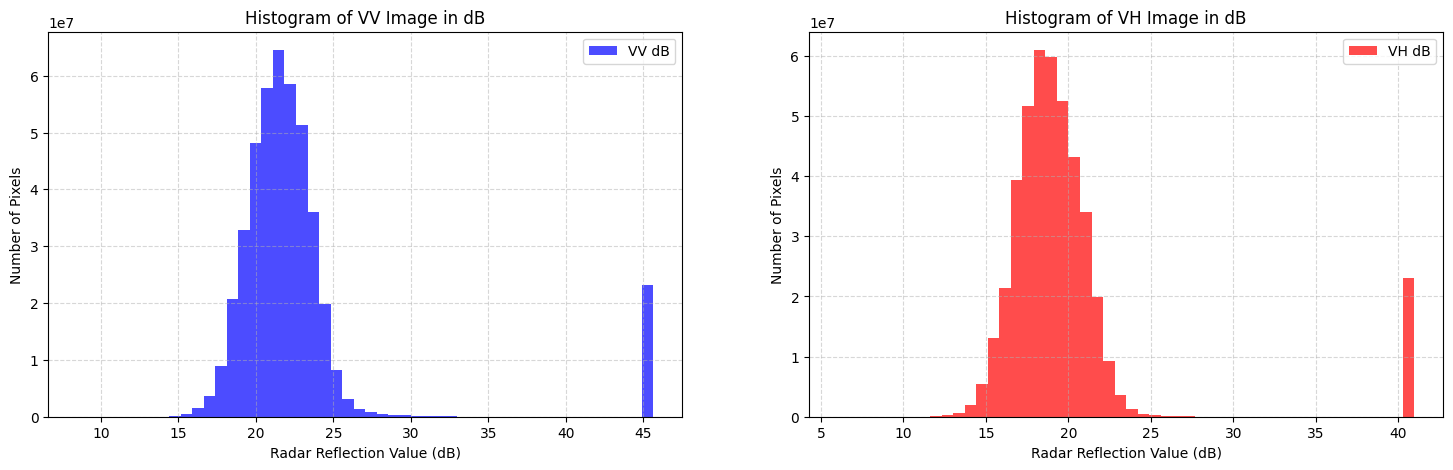

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Histogram of VV Image in dB
axs[0].hist(vv_band_db.flatten(), bins=50, color='blue', alpha=0.7, label='VV dB')
axs[0].set_title('Histogram of VV Image in dB')
axs[0].set_xlabel('Radar Reflection Value (dB)')
axs[0].set_ylabel('Number of Pixels')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Histogram of VH Image in dB
axs[1].hist(vh_band_db.flatten(), bins=50, color='red', alpha=0.7, label='VH dB')
axs[1].set_title('Histogram of VH Image in dB')
axs[1].set_xlabel('Radar Reflection Value (dB)')
axs[1].set_ylabel('Number of Pixels')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.show()

# Function to apply a threshold to an image
# Pixels greater than the threshold are set to 1, others to 0
def thresholding(image, threshold):
    return (image > threshold).astype(np.uint8)

# Define threshold values for VV and VH bands
threshold_value_vv = 23.5
threshold_value_vh = 21.5

# Apply thresholding to the VV and VH band
vv_band_threshold = thresholding(vv_band_db, threshold_value_vv)
vh_band_threshold = thresholding(vh_band_db, threshold_value_vh)

# Combine the thresholded images using a logical AND operation
# The result is 1 where both VV and VH are above their respective thresholds
combined_threshold = np.logical_and(vv_band_threshold, vh_band_threshold).astype(np.uint8)


### 3.4. Images ploting 
Next on the subplots we can visualize the differences in radio signal reflection for various polarization types. By displaying the original and decibel-transformed images for both VV and VH polarizations, we can observe distinct features and intensities in urban areas. The change in signal reflection in the original images is barely visible, which proves the usefulness of using a decibel scale. Furthermore, by combining information from both polarizations through thresholding, we enhance our ability to mask urbanized regions, providing a more comprehensive understanding of the observed area's urban characteristics.

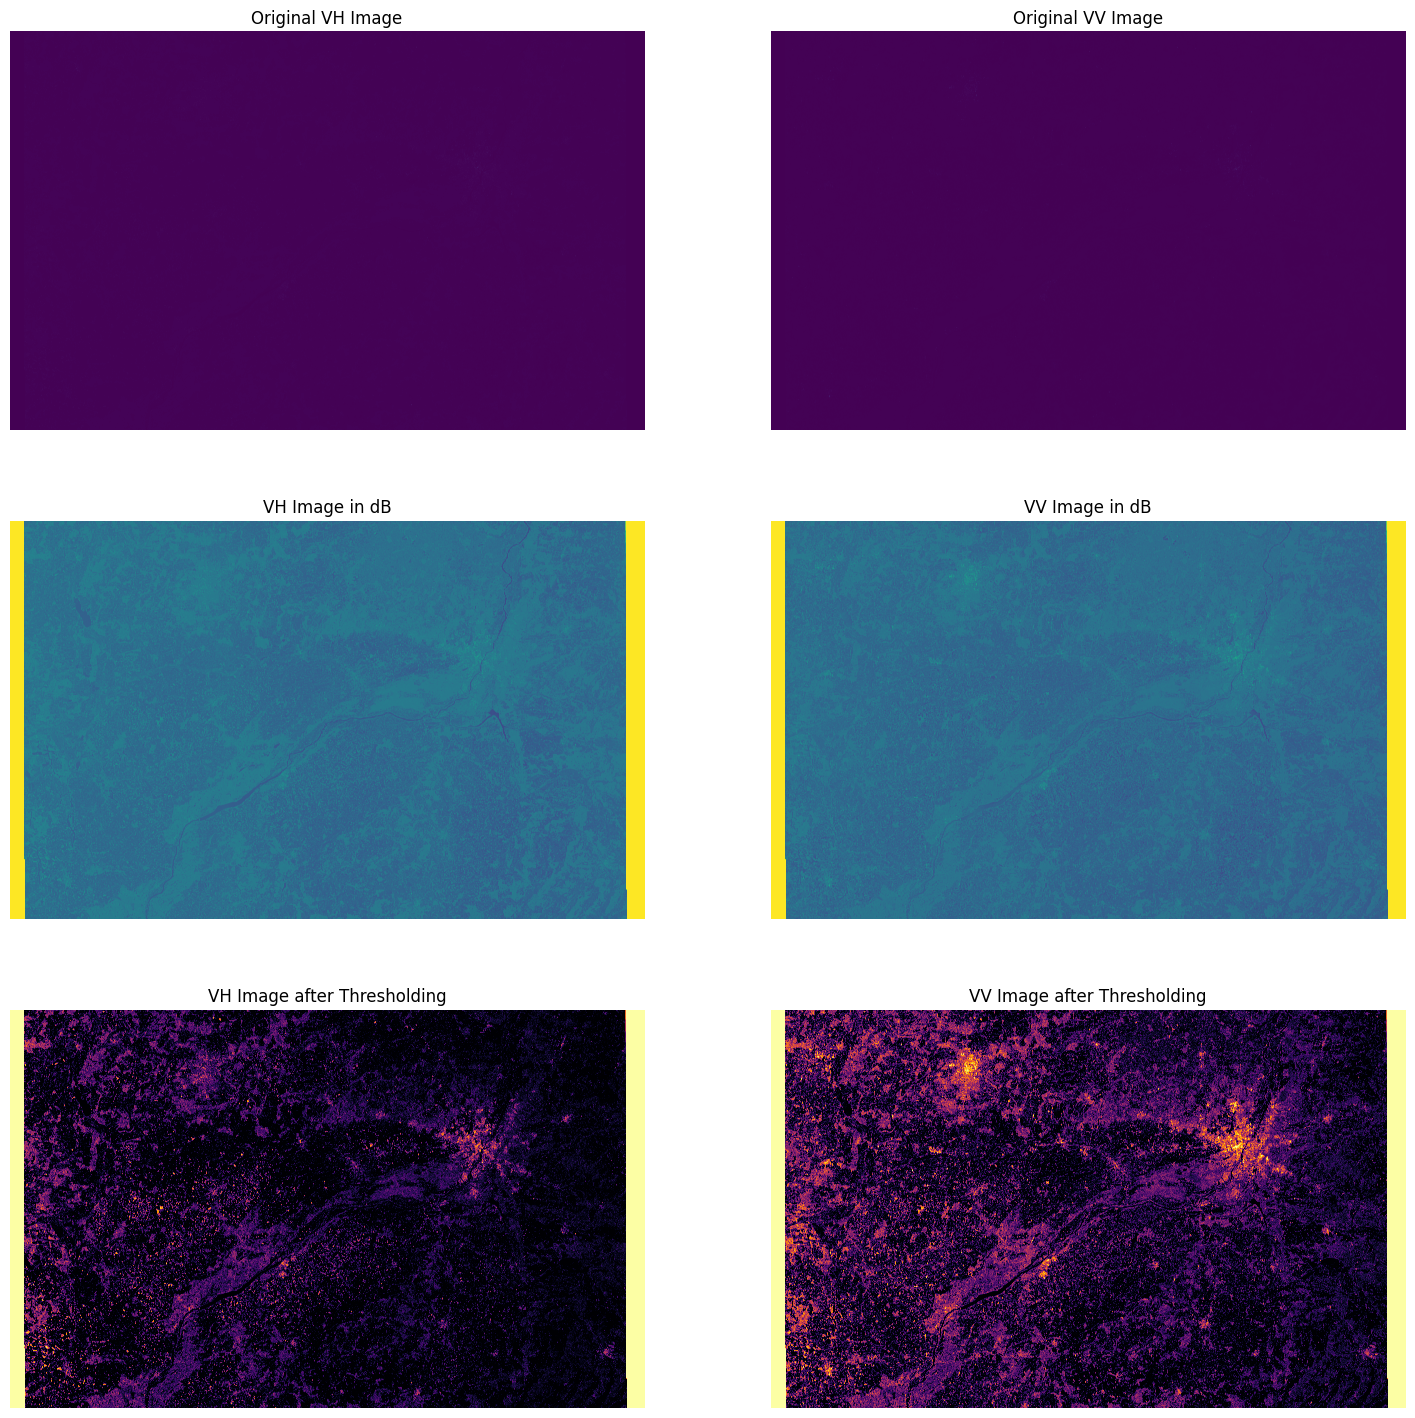

In [9]:
# Create a figure with a 3x2 grid of subplots, setting the overall figure size
fig, ax = plt.subplots(3, 2, figsize=(18, 18)) 

# Display the original VV image
ax[0, 1].imshow(vv_band, cmap='viridis')
ax[0, 1].set_title('Original VV Image')

# Display the VV image in decibels
ax[1, 1].imshow(vv_band_db, cmap='viridis')
ax[1, 1].set_title('VV Image in dB')

# Display the VV image after thresholding
ax[2, 1].imshow(vv_band_threshold, cmap='inferno')
ax[2, 1].set_title('VV Image after Thresholding')

# Display the original VH image
ax[0, 0].imshow(vh_band, cmap='viridis')
ax[0, 0].set_title('Original VH Image')

# Display the VH image in decibels
ax[1, 0].imshow(vh_band_db, cmap='viridis')
ax[1, 0].set_title('VH Image in dB')

# Display the VH image after thresholding
ax[2, 0].imshow(vh_band_threshold, cmap='inferno')
ax[2, 0].set_title('VH Image after Thresholding')

# Turn off the axes for all subplots to improve the visual presentation
for i in range(2):
    for j in range(3):
        ax[j, i].axis('off')

# Show the complete figure
plt.show()

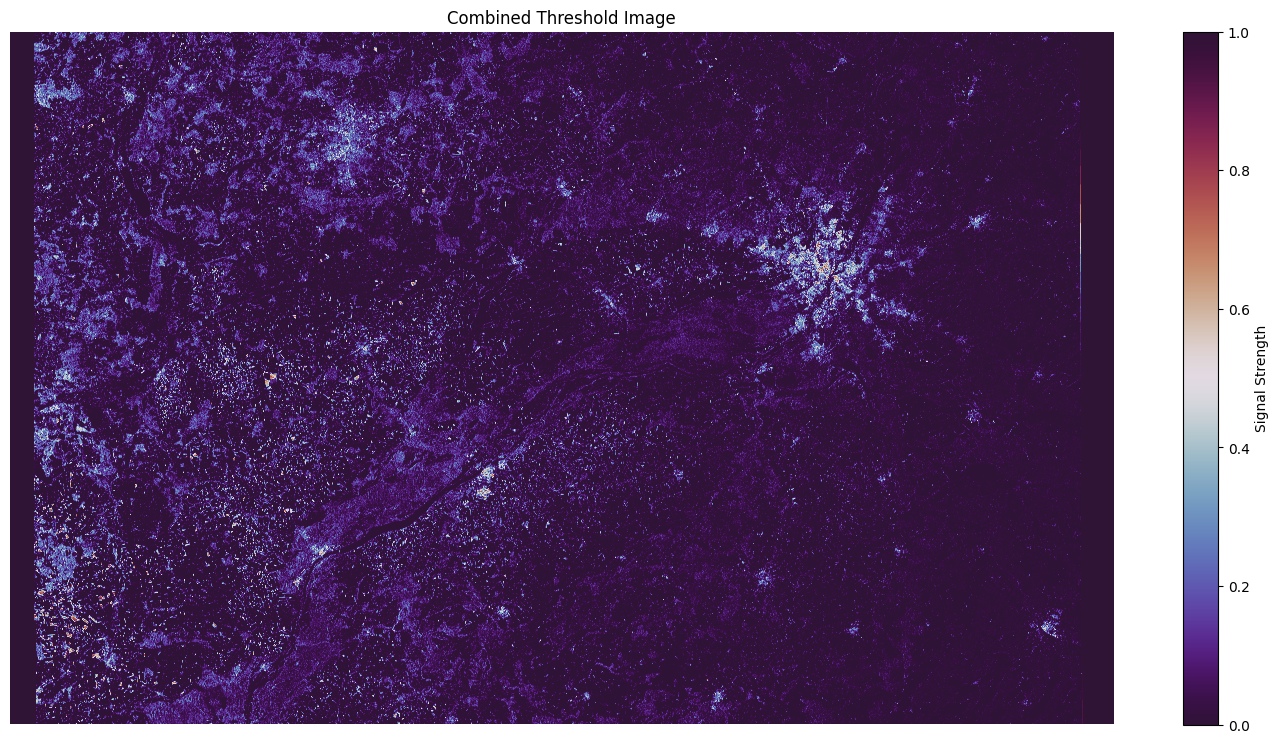

In [10]:
# Display the combined threshold image using a specific colormap
plt.figure(figsize=(18, 9))
im = plt.imshow(combined_threshold, cmap='twilight_shifted')
plt.title('Combined Threshold Image')
cbar = plt.colorbar(im)
cbar.set_label('Signal Strength')
plt.axis('off')
plt.show()

This method of data analysis facilitates straightforward masking of urbanized areas. In the processed image, the Warsaw agglomeration is clearly visible on the right side. A star-shaped accumulation of population is apparent in Warsaw along major transportation corridors such as railways and expressways. Smaller urban centers are visible in the image. Furthermore, it can be observed that the number of masked pixels accumulates as we approach the city center, indicating denser urban development in the downtown area compared to the suburbs.

### 3.5. Quantitative analysis
After processing our satellite images, we can conduct quantitative analysis. The characteristics of the satellite data enable us to analyze individual pixel values, which is crucial for detailed and statistical studies. In our case, having the data thresholded and the size of each pixel being 10x10 meters, we can calculate the percentage and the adequate size of the urbanized area.

In [11]:
# Calculate the number of urban pixels by summing up the binary values in the combined threshold image
urban_pixels = np.sum(combined_threshold)

# Define the area covered by a single pixel (in square meters)
pixel_area = 10 * 10  # Assuming each pixel represents a 10m x 10m area

# Calculate the total urban area in square meters
urban_area = urban_pixels * pixel_area

# Calculate the total number of pixels in the combined threshold image
total_pixels = combined_threshold.size

# Calculate the percentage of urbanized area in the image
urban_percentage = (urban_pixels / total_pixels) * 100

# Convert urban area from square meters to hectares
urban_area_hectares = urban_area / 10_000  

# Convert total area from square meters to hectares
total_area_hectares = (total_pixels * pixel_area) / 10_000

print(f"Percentage of Urbanized Area: {urban_percentage:.2f}%")
print(f"Urbanized Area: {urban_area_hectares:.2f} ha")
print(f"Total Image Area: {total_area_hectares:.2f} ha")

Percentage of Urbanized Area: 9.08%
Urbanized Area: 401728.18 ha
Total Image Area: 4426150.50 ha


### 3.6. Results download

In [12]:
# Define output file names
output_file_db_vv = 'vv_db_urban_warsaw.tif'
output_file_db_vh = 'vh_db_urban_warsaw.tif'
output_file_threshold_combined = 'warsaw_urban_threshold_combined.tif'

# Update the data type in the profile to float32 for dB conversion
profile_vv.update(dtype=rasterio.float32)
profile_vh.update(dtype=rasterio.float32)

# Write the result data in dB to the output file
with rasterio.open(output_file_db_vv, 'w', **profile_vv) as dst:
    dst.write(vv_band_db.astype(np.float32), 1)
    
with rasterio.open(output_file_db_vh, 'w', **profile_vh) as dst:
    dst.write(vh_band_db.astype(np.float32), 1)

# Update the data type in the VV profile to uint8 for the combined thresholded image
profile_vv.update(dtype=rasterio.uint8)

# Write the combined thresholded image data to the output file
with rasterio.open(output_file_threshold_combined, 'w', **profile_vv) as dst:
    dst.write(combined_threshold, 1)